In [1]:

import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Tamb = 25.3 + 273.15 # K
Pamb = 98.5 # kPa
c0 = 20.047 * Tamb**0.5
rho = 1.290 * Pamb / 101.325 * 273.15 / Tamb
z0 = rho*c0


In [3]:
def correct_wavenumber(t11, freq, d):
    
    idx = (freq > 100) & (freq< 3500)

    real_kc = np.zeros(freq[idx].size)
    imag_kc = np.zeros(freq[idx].size)

    t11_red = np.abs(np.imag(t11[idx]))
    idx_min = np.argmin(t11_red)

    # Shit the function when Imag(T11)=0
    if idx_min > 1:
        real_kc[:idx_min] = (np.real((1/d) * np.arccos((t11[idx]))))[:idx_min]
        imag_kc[:idx_min] = (np.imag((1/d) * np.arccos((t11[idx]))))[:idx_min]
    
    if idx_min <= t11_red.size:
        real_kc[idx_min:] = (1/d) * (2*np.pi - np.real(np.arccos((t11[idx]))))[idx_min:]
        imag_kc[idx_min:] = -(1/d) * np.imag(np.arccos((t11[idx])))[idx_min:]
    
    # window_size = 5
    # real_kc = np.convolve(real_kc, np.ones(window_size)/window_size, mode='same')
    # imag_kc = np.convolve(imag_kc, np.ones(window_size)/window_size, mode='same')
        
    return real_kc, imag_kc

def postproc_4mic(files, ds, s1=45e-3, s2=45e-3, l1=30e-3, l2=50e-3+30e-3, Tamb=25, Pamb=98.5):
    
    # ds = Sample thickness [m] 
    
    meas_1234 = io.loadmat(files[0])
    meas_2134 = io.loadmat(files[1])    
    meas_3214 = io.loadmat(files[2]) 
    meas_4231 = io.loadmat(files[3])

    freq = meas_1234['FFT1_H1_2_1_X_Val'].flatten()

    H12d = meas_1234['FFT1_H1_2_1_Y_ReIm'].flatten()
    H13d = meas_1234['FFT1_H1_3_1_Y_ReIm'].flatten()
    H14d = meas_1234['FFT1_H1_4_1_Y_ReIm'].flatten()

    H12i = meas_2134['FFT1_H1_2_1_Y_ReIm'].flatten()
    H13i = meas_3214['FFT1_H1_3_1_Y_ReIm'].flatten()
    H14i = meas_4231['FFT1_H1_4_1_Y_ReIm'].flatten()
    
    Hc12 = (H12d * H12i)**0.5
    Hc13 = (H13d * H13i)**0.5 
    Hc14 = (H14d * H14i)**0.5
    
    Hf11 = 1
    Hf12 = H12d/Hc12
    Hf13 = H13d/Hc13 
    Hf14 = H14d/Hc14
    
    TambK = Tamb + 273.15 # K
    c0 = 20.047 * TambK**0.5
    rho = 1.290 * Pamb / 101.325 * 273.15 / TambK
    z0 = rho*c0

    k = 2*np.pi*freq / c0

    a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1))) 
    b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1))) 
    c = 1j*((Hf13*np.exp(1j*k*(l2+s2)) - Hf14*np.exp(1j*k*(l2))) / (2*np.sin(k*s2))) 
    d = 1j*((Hf14*np.exp(-1j*k*l2) - Hf13*np.exp(-1j*k*(l2+s2))) / (2*np.sin(k*s2)))

    p0 = a + b
    pd = c*np.exp(-1j*k*ds) + d*np.exp(1j*k*ds)
    u0 = (a - b) / (z0) 
    ud = (c*np.exp(-1j*k*ds) - d*np.exp(1j*k*ds)) / (z0)

    Tm11 = ((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm12 = ((p0**2 - pd**2) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm21 = ((u0**2 - ud**2) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm22 =((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)

    #T_matrix = np.matrix([[T11 , T12], [T21 ,T22]])
    T_matrix = np.empty((2,2), dtype=object)
    T_matrix[0, 0] = Tm11
    T_matrix[0, 1] = Tm12
    T_matrix[1, 0] = Tm21
    T_matrix[1, 1] = Tm22

    R_coef = (T_matrix[0, 0] - rho*c0*T_matrix[1, 0]) / (T_matrix[0, 0] + rho*c0*T_matrix[1, 0]) 
    alpha_coef = 1 - np.abs(R_coef)**2
    #kc = (1/d) * np.arccos(T_matrix[0, 0])
    Zc = np.sqrt(T_matrix[0, 1] / T_matrix[1, 0])
    
    real_kc, imag_kc = correct_wavenumber(T_matrix[0,0], freq, ds)
    kc_corr = real_kc + 1j*imag_kc
    phase_uw = np.unwrap(np.angle(kc_corr), discont=np.pi/10, period=0.0001)  # Correct any possible small spike or jump in the phase
    kc_corr = np.abs(kc_corr) * np.exp(1j*phase_uw)   
    
    return freq, R_coef, alpha_coef, kc_corr, Zc


In [4]:
files = ['YM2_coarse_d1_s1_anec_0,5V_1234.mat', 'YM2_coarse_d1_s1_anec_0,5V_2134.mat', 'YM2_coarse_d1_s1_anec_0,5V_3214.mat', 'YM2_coarse_d1_s1_anec_0,5V_4231.mat']
files2 = ['YM2_coarse_d1_s1_anec_1V_1234.mat', 'YM2_coarse_d1_s1_anec_1V_2134.mat', 'YM2_coarse_d1_s1_anec_1V_3214.mat', 'YM2_coarse_d1_s1_anec_1V_4231.mat']
files3 = ['YM2_coarse_d1_s1_anec_1V_500mm_1234.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_2134.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_3214.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_4231.mat']

l1 = 30e-3
s1 = 45e-3
l2 = 50e-3 + 30e-3
s2 = 45e-3
d = 43e-3

freq, R_anec_low, alpha_anec_low, kc_anec_low, Zc_anec_low = postproc_4mic(files, d, s1, s2, l1, l2)
freq, R_anec_1V, alpha_anec_1V, kc_anec_1V, Zc_anec_1V = postproc_4mic(files2, d)
freq, R_anec_1V_500, alpha_anec_1V_500, kc_anec_1V_500, Zc_anec_1V_500 = postproc_4mic(files3, d, 500e-3, 500e-3, l1, l2)





C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:61: RuntimeWarning: divide by zero encountered in divide
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:61: RuntimeWarning: invalid value encountered in divide
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:62: RuntimeWarning: divide by zero encountered in divide
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:62: RuntimeWarning: invalid value encountered in divide
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:63: RuntimeWarning: divide by zero encountered in divide
  c = 1j*((Hf13*np.exp(1j*k*(l2+s2)) - Hf14*np.exp(1j*k

In [5]:
%matplotlib inline


c:\Users\J.Garcia\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


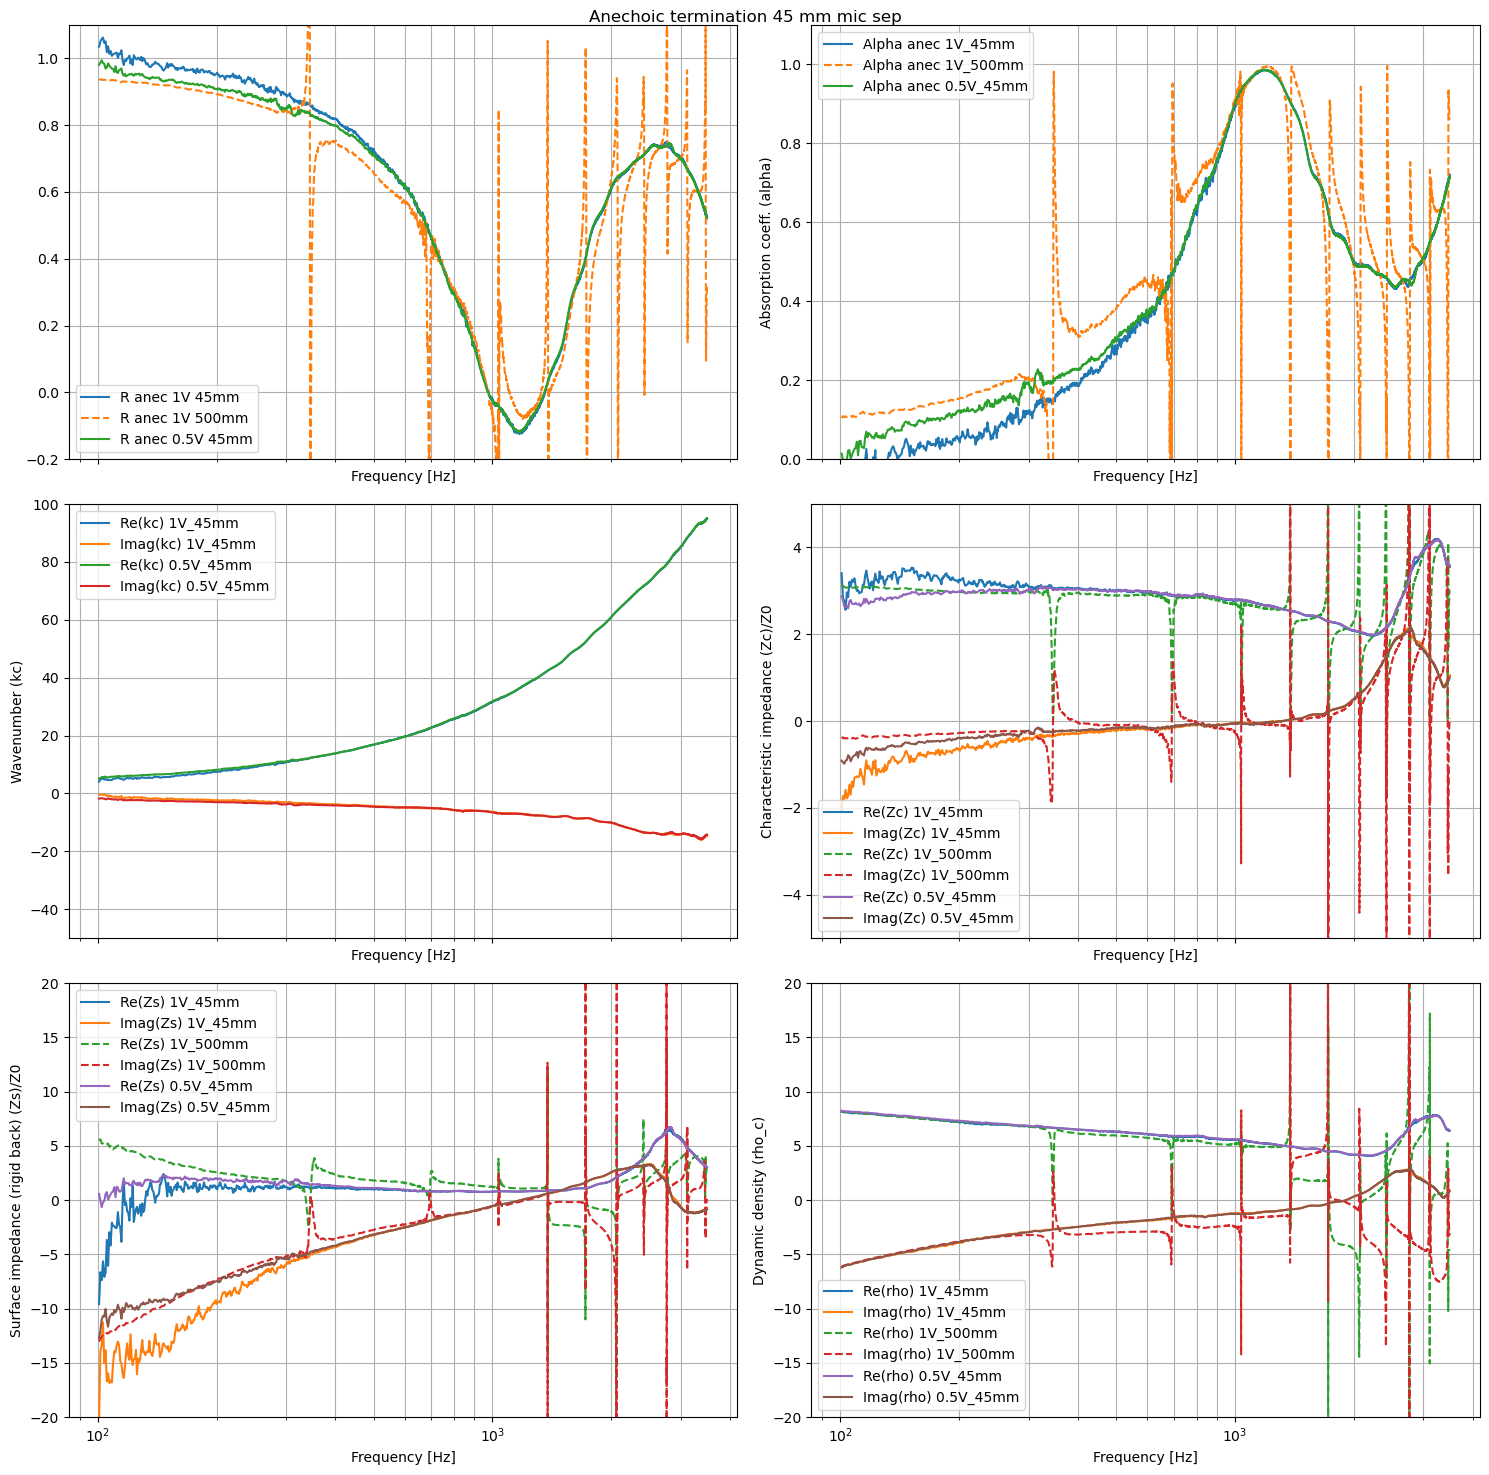

In [6]:
idx = (freq > 100) & (freq< 3500)

fig, ax = plt.subplots(3,2, figsize=(15, 15) ,sharex=True)
ax = ax.flatten()

ax[0].semilogx(freq[idx], R_anec_1V[idx], label='R anec 1V 45mm')
ax[0].semilogx(freq[idx], R_anec_1V_500[idx], '--' ,label='R anec 1V 500mm')
ax[0].semilogx(freq[idx], R_anec_low[idx], label='R anec 0.5V 45mm')

# Absorption coefficient
ax[1].semilogx(freq[idx], alpha_anec_1V[idx], label='Alpha anec 1V_45mm')
ax[1].semilogx(freq[idx], alpha_anec_1V_500[idx], '--', label='Alpha anec 1V_500mm')
ax[1].semilogx(freq[idx], alpha_anec_low[idx], label='Alpha anec 0.5V_45mm')

# Wavenumber
ax[2].semilogx(freq[idx], kc_anec_1V.real, label='Re(kc) 1V_45mm ')
ax[2].semilogx(freq[idx], kc_anec_1V.imag, label='Imag(kc) 1V_45mm')
#ax[2].semilogx(freq[idx], kc_anec_1V_500.real, '--' ,label='Re(kc) 1V_500mm')
#ax[2].semilogx(freq[idx], kc_anec_1V_500.imag, '--' ,label='Imag(kc) 1V_500mm')
ax[2].semilogx(freq[idx], kc_anec_low.real, label='Re(kc) 0.5V_45mm')
ax[2].semilogx(freq[idx], kc_anec_low.imag, label='Imag(kc) 0.5V_45mm')

#Characteristic impedance
ax[3].semilogx(freq[idx], (Zc_anec_1V[idx].real)/z0, label='Re(Zc) 1V_45mm')
ax[3].semilogx(freq[idx], (Zc_anec_1V[idx].imag)/z0, label='Imag(Zc) 1V_45mm')
ax[3].semilogx(freq[idx], (Zc_anec_1V_500[idx].real)/z0,  '--',label='Re(Zc) 1V_500mm')
ax[3].semilogx(freq[idx], (Zc_anec_1V_500[idx].imag)/z0,  '--',label='Imag(Zc) 1V_500mm')
ax[3].semilogx(freq[idx], (Zc_anec_low[idx].real)/z0, label='Re(Zc) 0.5V_45mm')
ax[3].semilogx(freq[idx], (Zc_anec_low[idx].imag)/z0, label='Imag(Zc) 0.5V_45mm')

# Surface impedance rigid back-end:
Zs_anec_1V = -1j * ((Zc_anec_1V[idx])/z0) * (1/np.tan(kc_anec_1V * d))
ax[4].semilogx(freq[idx], Zs_anec_1V.real, label='Re(Zs) 1V_45mm')
ax[4].semilogx(freq[idx], Zs_anec_1V.imag, label='Imag(Zs) 1V_45mm')

Zs_anec_1V_500 = -1j * ((Zc_anec_1V_500[idx])/z0) * (1/np.tan(kc_anec_1V_500 * d))
ax[4].semilogx(freq[idx], Zs_anec_1V_500.real, '--', label='Re(Zs) 1V_500mm')
ax[4].semilogx(freq[idx], Zs_anec_1V_500.imag, '--',label='Imag(Zs) 1V_500mm')

Zs_anec_low = -1j * ((Zc_anec_low[idx])/z0) * (1/np.tan(kc_anec_low * d))
ax[4].semilogx(freq[idx], Zs_anec_low.real, label='Re(Zs) 0.5V_45mm')
ax[4].semilogx(freq[idx], Zs_anec_low.imag, label='Imag(Zs) 0.5V_45mm')

# Dynamic density
rho_anec_1V = (Zc_anec_1V[idx] * kc_anec_1V) / (2*np.pi*freq[idx])
ax[5].semilogx(freq[idx], rho_anec_1V.real, label='Re(rho) 1V_45mm')
ax[5].semilogx(freq[idx], rho_anec_1V.imag, label='Imag(rho) 1V_45mm')

rho_anec_1V_500 = (Zc_anec_1V_500[idx] * kc_anec_1V_500) / (2*np.pi*freq[idx])
ax[5].semilogx(freq[idx], rho_anec_1V_500.real, '--',label='Re(rho) 1V_500mm')
ax[5].semilogx(freq[idx], rho_anec_1V_500.imag, '--',label='Imag(rho) 1V_500mm')

rho_anec_low = (Zc_anec_low[idx] * kc_anec_low) / (2*np.pi*freq[idx])
ax[5].semilogx(freq[idx], rho_anec_low.real, label='Re(rho) 0.5V_45mm')
ax[5].semilogx(freq[idx], rho_anec_low.imag, label='Imag(rho) 0.5V_45mm')


ax[0].set_ylim([-0.2, 1.1])
ax[1].set_ylim([0, 1.1])
ax[2].set_ylim([-50, 100])
ax[3].set_ylim([-5, 5])
ax[4].set_ylim([-20, 20])
ax[5].set_ylim([-20, 20])

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()

ax[0].grid(which='both')
ax[1].grid(which='both')
ax[2].grid(which='both')
ax[3].grid(which='both')
ax[4].grid(which='both')
ax[5].grid(which='both')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].set_xlabel('Frequency [Hz]')
ax[4].set_xlabel('Frequency [Hz]')
ax[5].set_xlabel('Frequency [Hz]')

ax[1].set_ylabel('Reflection coeff. (R)')
ax[1].set_ylabel('Absorption coeff. (alpha)')
ax[2].set_ylabel('Wavenumber (kc)')
ax[3].set_ylabel('Characteristic impedance (Zc)/Z0')
ax[4].set_ylabel('Surface impedance (rigid back) (Zs)/Z0')
ax[5].set_ylabel('Dynamic density (rho_c)')

plt.suptitle('Anechoic termination 45 mm mic sep')
plt.tight_layout()

plt.show()

### Measurement with short mic separation (45 mm), anechoic termination, 0.5V source

In [7]:
#!pip install ipympl
#%matplotlib widget
%matplotlib inline
#import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use('module://ipympl')
#import ipywidgets as widgets

### Measurement with short mic separation (45 mm), rigid termination

In [8]:
files4 = ['YM2_coarse_d1_s1_rigid_1V_1234.mat', 'YM2_coarse_d1_s1_rigid_1V_2134.mat', 'YM2_coarse_d1_s1_rigid_1V_3214.mat', 'YM2_coarse_d1_s1_rigid_1V_4231.mat']
freq, R_rigid_1V, alpha_rigid_1V, kc_rigid_1V, Zc_rigid_1V = postproc_4mic(files4, d)

C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:61: RuntimeWarning: divide by zero encountered in divide
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:61: RuntimeWarning: invalid value encountered in multiply
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:62: RuntimeWarning: divide by zero encountered in divide
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:62: RuntimeWarning: invalid value encountered in multiply
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\J.Garcia\AppData\Local\Temp\ipykernel_29532\285304353.py:63: RuntimeWarning: divide by zero encountered in divide
  c = 1j*((Hf13*np.exp(1j*k*(l2+s2)) - Hf14*np.exp(

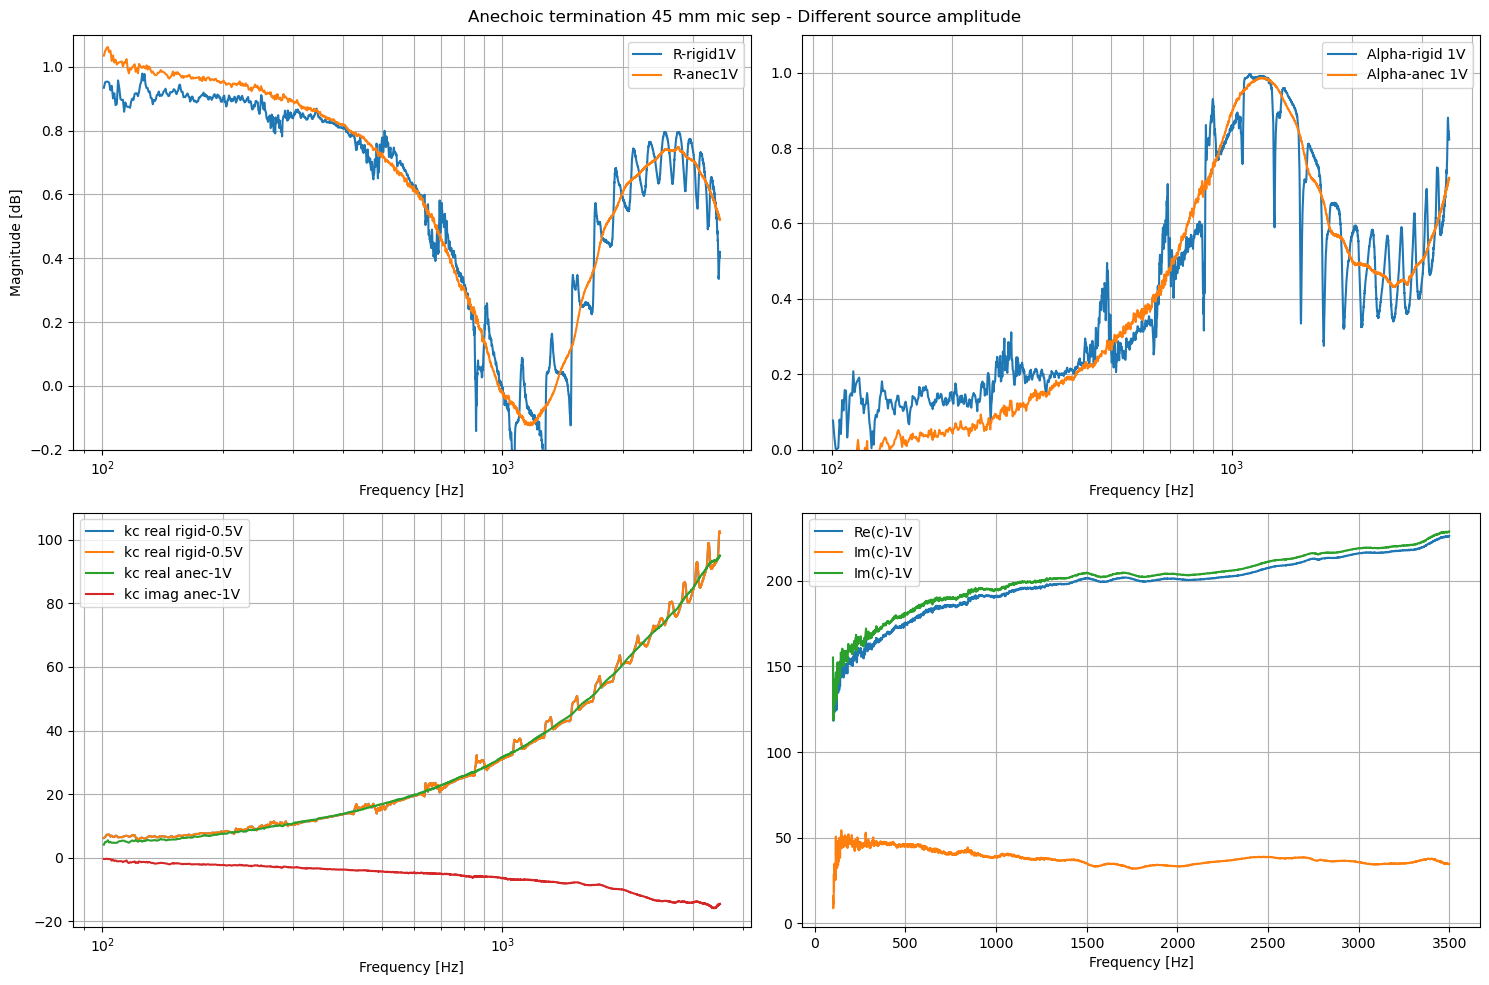

In [9]:
idx = (freq > 100) & (freq< 3500)

fig, ax = plt.subplots(2,2, figsize=(15, 10) ,sharex=False)
ax = ax.flatten()

ax[0].semilogx(freq[idx], R_rigid_1V[idx], label='R-rigid1V')
ax[0].semilogx(freq[idx], R_anec_1V[idx], label='R-anec1V')

ax[1].semilogx(freq[idx], alpha_rigid_1V[idx], label='Alpha-rigid 1V')
ax[1].semilogx(freq[idx], alpha_anec_1V[idx], label='Alpha-anec 1V')

ax[2].semilogx(freq[idx], kc_rigid_1V, label='kc real rigid-0.5V')
ax[2].semilogx(freq[idx], kc_rigid_1V, label='kc real rigid-0.5V')
ax[2].semilogx(freq[idx], kc_anec_1V.real, label='kc real anec-1V')
ax[2].semilogx(freq[idx], kc_anec_1V.imag, label='kc imag anec-1V')
#ax[2].set_xlim([2480, 2500])
#ax[2].set_ylim([-1, 1])

c_anec = 2*np.pi*freq[idx]/kc_anec_1V
ax[3].plot(freq[idx], (c_anec).real, label='Re(c)-1V')
ax[3].plot(freq[idx], c_anec.imag, label='Im(c)-1V')
ax[3].plot(freq[idx], abs(c_anec), label='Im(c)-1V')

c_rigid = 2*np.pi*freq[idx]/kc_rigid_1V
#ax[3].semilogx(freq[idx], (c_rigid).real, label='Re(c)-1V')
#ax[3].semilogx(freq[idx], c_rigid.imag, label='Im(c)-1V')


ax[0].legend()
ax[0].set_ylabel('Magnitude [dB]')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].set_ylim([-0.2, 1.1])
ax[1].set_ylim([0, 1.1])

ax[0].grid(which='both')
ax[1].grid(which='both')
ax[2].grid(which='both')
ax[3].grid(which='both')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].set_xlabel('Frequency [Hz]')

plt.suptitle('Anechoic termination 45 mm mic sep - Different source amplitude')
plt.tight_layout()

plt.show()

### Measurement with long mic separation (500 mm), rigid termination